## Analysis of an E-commerce Dataset Part 2

The goal of the second analysis task is to train linear regression models to predict users' ratings towards items. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned combined e-commerce sub-dataset that **is different from** the one in “Analysis of an E-commerce Dataset” task 1.

### Import Cleaned E-commerce Dataset
The csv file named 'cleaned_ecommerce_dataset.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [1]:
#import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import OrdinalEncoder
from textblob import TextBlob

In [2]:

#reading data from the .csv file
data_set = 'data/cleaned_ecommerce_dataset.csv'
#storing data into dataframe
data_frame = pd.read_csv(data_set)

In [3]:

print(len(data_frame))

2685


### Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict ratings given other columns, please get the correlations between helpfulness/gender/category/review and rating by using the `corr()` method.
* To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, category and review) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ corrleated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

**providing a rough picture about the data**

In [4]:
data_frame.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category,item_id,item_price,user_city
0,4081,71900,Not always McCrap,McDonald's,4.0,3.0,M,Restaurants & Gourmet,41,30.74,4
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,1.0,4.0,M,Restaurants & Gourmet,74,108.30,4
2,4081,72000,The Wonderful World of Wendy,Wendy's,5.0,4.0,M,Restaurants & Gourmet,84,69.00,4
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",5.0,3.0,M,Movies,68,143.11,4
4,4081,100399,Hey! Gimme some pie!,American Pie,3.0,3.0,M,Movies,6,117.89,4


In [5]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   rating       2685 non-null   float64
 5   helpfulness  2685 non-null   float64
 6   gender       2685 non-null   object 
 7   category     2685 non-null   object 
 8   item_id      2685 non-null   int64  
 9   item_price   2685 non-null   float64
 10  user_city    2685 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 230.9+ KB


In [6]:
data_frame.dtypes

userId           int64
timestamp        int64
review          object
item            object
rating         float64
helpfulness    float64
gender          object
category        object
item_id          int64
item_price     float64
user_city        int64
dtype: object

**converting the categorical features (i.e., gender, category and review) into numerial values**

ordinal encoder is used for converting gender and category into numerical values. 
TextBlob is used to convert sentiment from the reviews into a numerical value. Simply using ordinal encoder would make no sense in this case because every review could be unique but we require the nature and sentiment behind a review in order to correlate it with the rating. This is in no form a perfect method, however it is a decent estimation. Higher value means positive sentiment and lower value means no or negative sentiment.

In [7]:
# Initialize OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the gender and category columns
data_frame['gender_encoded'] = encoder.fit_transform(data_frame[['gender']])
data_frame['category_encoded'] = encoder.fit_transform(data_frame[['category']])
data_frame['review_encoded'] = data_frame['review'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [8]:
# Calculate correlations
correlation_columns = ['rating', 'helpfulness', 'gender_encoded', 'category_encoded', 'review_encoded']
correlation_data = data_frame[correlation_columns]
correlation_matrix = correlation_data.corr()


In [9]:
correlation_data

,rating,helpfulness,gender_encoded,category_encoded,review_encoded
0,4.0,3.0,1.0,8.0,0.000
1,1.0,4.0,1.0,8.0,0.000
2,5.0,4.0,1.0,8.0,1.000
3,5.0,3.0,1.0,5.0,0.000
4,3.0,3.0,1.0,5.0,0.000
...,...,...,...,...,...
2680,5.0,3.0,1.0,5.0,1.000
2681,5.0,3.0,1.0,8.0,0.875
2682,5.0,3.0,1.0,5.0,1.000
2683,5.0,4.0,1.0,1.0,0.300


In [10]:
# Display the correlation matrix for rating
print(correlation_matrix['rating'])

rating              1.000000
helpfulness        -0.007523
gender_encoded     -0.034337
category_encoded   -0.163158
review_encoded      0.215772
Name: rating, dtype: float64


**ANALYSIS**

Using the corr() method, values close to 1 show strong positive correlation, values close to -1 show strong negative correlation, values close to 0 show weak or no correlation. From the correlation matrix, we can easily find that the features with highest correlation with `rating` are `review_encoded` and `category_encoded` so these are the most correlated features. `gender_encoded` and `helpfulness` are the least correlated features. This makes sense for reviews in the way that a review with positive sentiments would obvious correspond to a higher rating and vice versa. Also as we know from real life experiences, some categories will always tend to get negatively rated more than others.

It should be noted that even for being the most correlated features, the actual value of correlation is very low for `review_encoded` and `category_encoded`. At this stage, it would be fair to assume that because there aren't huge differences in these values, the predictions of linear regression models trained using these features would be pretty close, although the models trained on the higher correlated features would still obviously be better.

**To summarise:**
- **Most correlated features**: `review_encoded`, `category_encoded`
- **Least correlated features**: `gender_encoded`, `gender_encoded`
- **Hypothesis**: 'predictions for models trained on most correlated features would be better than models trained on least correlated features. The predictions would be fairly close'

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [11]:
train_case1, test_case1 = train_test_split(correlation_data, test_size=0.9, random_state=142)
train_case2, test_case2 = train_test_split(correlation_data, test_size=0.1, random_state=142)

print("Case 1:")
print(f"Shape of Training Data: {train_case1.shape}")
print(f"Shape of Testing Data: {test_case1.shape}")

print("Case 2:")
print(f"Shape of Training Data: {train_case2.shape}")
print(f"Shape of Testing Data: {test_case2.shape}")

Case 1:
Shape of Training Data: (268, 5)
Shape of Testing Data: (2417, 5)
Case 2:
Shape of Training Data: (2416, 5)
Shape of Testing Data: (269, 5)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features regarding rating, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

In [12]:
model_a = linear_model.LinearRegression()

X_a_train = train_case1[['review_encoded', 'category_encoded']]
Y_a_train = train_case1['rating']

X_a_test = test_case1[['review_encoded', 'category_encoded']]
Y_a_test = test_case1['rating']

model_a.fit(X_a_train, Y_a_train)

LinearRegression()

In [13]:
model_b = linear_model.LinearRegression()

X_b_train = train_case1[['gender_encoded', 'helpfulness']]
Y_b_train = train_case1['rating']

X_b_test = test_case1[['gender_encoded', 'helpfulness']]
Y_b_test = test_case1['rating']

model_b.fit(X_b_train, Y_b_train)

LinearRegression()

In [14]:
model_c = linear_model.LinearRegression()

X_c_train = train_case2[['review_encoded', 'category_encoded']]
Y_c_train = train_case2['rating']

X_c_test = test_case2[['review_encoded', 'category_encoded']]
Y_c_test = test_case2['rating']

model_c.fit(X_c_train, Y_c_train)

LinearRegression()

In [15]:
model_d = linear_model.LinearRegression()

X_d_train = train_case2[['gender_encoded', 'helpfulness']]
Y_d_train = train_case2['rating']

X_d_test = test_case2[['gender_encoded', 'helpfulness']]
Y_d_test = test_case2['rating']

model_d.fit(X_d_train, Y_d_train)

LinearRegression()

### Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [16]:
prediction_a = model_a.predict(X_a_test)

mse_a = ((np.array(Y_a_test)-prediction_a)**2).sum()/len(Y_a_test)
root_mse_a = np.sqrt(mse_a)
print("Model A:")
print(f"MSE: {mse_a}")
print(f"Root MSE: {root_mse_a}")

Model A:
MSE: 1.688761533464577
Root MSE: 1.299523579418464


In [17]:
prediction_b = model_b.predict(X_b_test)

mse_b = ((np.array(Y_b_test)-prediction_b)**2).sum()/len(Y_b_test)
root_mse_b = np.sqrt(mse_b)
print("Model B:")
print(f"MSE: {mse_b}")
print(f"Root MSE: {root_mse_b}")

Model B:
MSE: 1.8412549895856636
Root MSE: 1.356928513071217


In [18]:
prediction_c = model_c.predict(X_c_test)

mse_c = ((np.array(Y_c_test)-prediction_c)**2).sum()/len(Y_c_test)
root_mse_c = np.sqrt(mse_c)
print("Model C:")
print(f"MSE: {mse_c}")
print(f"Root MSE: {root_mse_c}")

Model C:
MSE: 1.6238419523885013
Root MSE: 1.2743005738005855


In [19]:
prediction_d = model_d.predict(X_d_test)

mse_d = ((np.array(Y_d_test)-prediction_d)**2).sum()/len(Y_d_test)
root_mse_d = np.sqrt(mse_d)
print("Model D:")
print(f"MSE: {mse_d}")
print(f"Root MSE: {root_mse_d}")

Model D:
MSE: 1.8109460127732369
Root MSE: 1.3457139416581954


### Visualize, Compare and Analyze the Results
* Visualize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

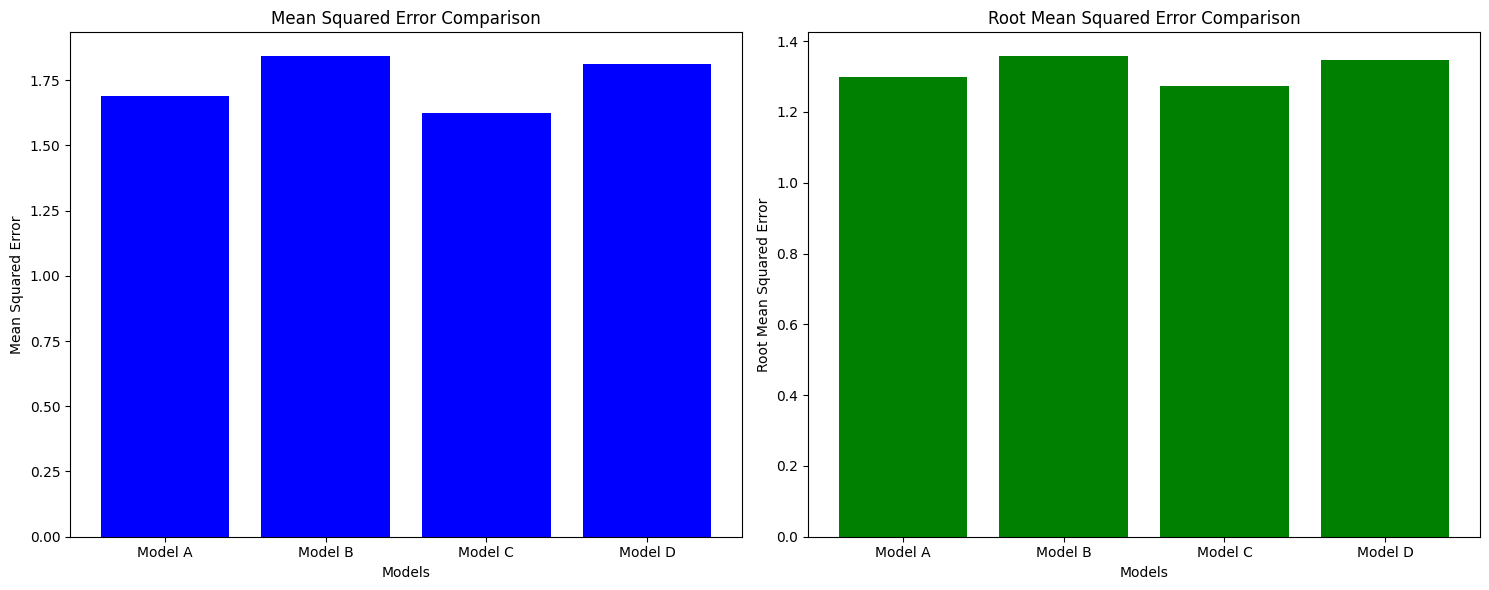

In [20]:
mse_values = [mse_a, mse_b, mse_c, mse_d]
rmse_values = [root_mse_a, root_mse_b, root_mse_c, root_mse_d]
model_names = ['Model A', 'Model B', 'Model C', 'Model D']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot for MSE values
ax1.bar(model_names, mse_values, color='blue')
ax1.set_xlabel('Models')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Mean Squared Error Comparison')

# Bar plot for RMSE values
ax2.bar(model_names, rmse_values, color='green')
ax2.set_xlabel('Models')
ax2.set_ylabel('Root Mean Squared Error')
ax2.set_title('Root Mean Squared Error Comparison')

# Adjust layout
plt.tight_layout()
plt.show()

**OBSERVATIONS**

- MSE and Root MSE values closer to 0 are ideal. Values of MSE for each model is greater than 1, so the values of Root MSE will also be greater than 1. Comparison of either set of values is sufficient, because the other set will not be providing any new information.

- *Comparing Model A and Model B:* Model A has a lower MSE than Model B by 10%. This means Model A is better than Model B. Proving the earlier hypothesis that the model trained using most correlated features would perform better than the model trained using least correlated features.
- *Comparing Model C and Model D:* Model C has a lower MSE than Model D by 10%. This means Model C is better than Model D. Again proving the earlier hypothesis that the model trained using most correlated features would perform better than the model trained using least correlated features.
- *Comparing Model A and Model C:* Model C has a slightly lower MSE than Model A. This means Model C is better than Model A. The model trained using 90% of the dataset for training performed better than the model trained on 10% of the dataset. This would be as expected, however the difference is so miniscule that it could just be left up to random chance. For example, the seed value for test_train_split could be altered to sway the results.
- *Comparing Model B and Model D:* Model D has a slightly lower MSE than Model B. This means Model D is better than Model B. Again, the model trained using 90% of the dataset performed better than the model trained on 10% of the dataset.

**CONCLUSION**

As hypothesized before, the correlation values of the "most correlated features" are low and hence the linear regression model would not be very efficient compared to even the "least correlated features". The models trained with most correlated features and more training data performed better than the other models. This means Model C should have been the best, and it indeed is the best out of all four models. 